# The Buy & Eco Queues

During actual games, players will have a predetermined set of purchases they intend to make and also a predetermined way of eco'ing that they've flowcharted out. The simulator can model taking these sorts of actions with the *buy queue* and the *eco queue*. In this tutorial, I'll show how to simulate flowcharts using these two features and then show how we refine them using optimization techniques. Like last time, let's import the `b2sim` module:

In [1]:
import b2sim as b2
import copy

## The Basics

For our toy example, let's consider a scenario where we are playing tack wiz farm with jericho and have approached round 9. In a typical game scenario, this means the player has the following farms and defense:

| Build Item | Current Build |
|------------|---------------|
| Farms      | 2 x 200 farms |
| Defense    | 1 x 230 tack  |
|            | 1 x 022 wizard|

By halfway through Round 10, we seek the following build

| Build Item | Current Build |
|------------|---------------|
| Farms      | 2 x 200 farms |
| Defense    | 1 x 230 tack  |
|            | 1 x 024 wizard|

Like last time, we'll start by determining the round lengths and specifying our farms:

In [2]:
rounds = b2.Rounds(0.25)

farms = {
    0: b2.initFarm(rounds.getTimeFromRound(5), upgrades = [2,0,0]),
    1: b2.initFarm(rounds.getTimeFromRound(8), upgrades = [2,0,0])
}

Now, we define the buy queue. The buy queue is a list of lists. Each item in the buy queue prescribes a list of actions the player wishes to take. Every time the player receives a payment in the simulator, the simulator will check whether there is enough cash to execute the next item in the buy queue. In most cases (such as this example), items in the buy queue will just be lists with one action, but for cases like selling farms into better farm upgrades or more defense, it is useful to have an item in the buy queue which prescribes multiple actions to be taken simultaneously. Note in our case we are also specifying a minimum time to perform each transaction. This tells the sim not to attempt the transaction until that time is reached in the simulation. A full list of actions that can be put into the buy queue is available in `actions.py`.

In [3]:
buy_queue = [
    [b2.jerichoSteal(steal_amount = 25, min_buy_time = rounds.getTimeFromRound(9.25))],
    [b2.buyDefense(2800+1500, min_buy_time = rounds.getTimeFromRound(10.5))]
]

Our next step is to define the eco queue. Items in the eco queue list are calls of the function `b2.ecoSend`, which tell the simulator to switch to the specified eco send at the specified time with the specified properties. In our case, we will send spaced zebras for a short while on round 9 before deciding to stop and hard save for necromancer. Note that our eco queue does not have spaced zebras. That's because we'll specify spaced zebras as the starting send in the initial game state.

In [4]:
eco_queue = [
    b2.ecoSend(rounds.getTimeFromRound(9) + 1.8, 'Zero', property = 'Normal', max_send_amount = None)
]

Make sure when defining the initial game state to include the queues we defined above!

In [5]:
initial_state_game = {
    'Cash': 1500,
    'Eco': 520,
    'Eco Send': 'Spaced Zebras',
    'Rounds': rounds,
    'Game Round': 9,
    'Farms': farms,
    'Buy Queue': copy.deepcopy(buy_queue),
    'Eco Queue': copy.deepcopy(eco_queue)
}

Finally, we can simulate. Here we want to check whether we can actually afford necromancer or not.

The current cash and eco are (1290.4000000000017,544.3000000000004)


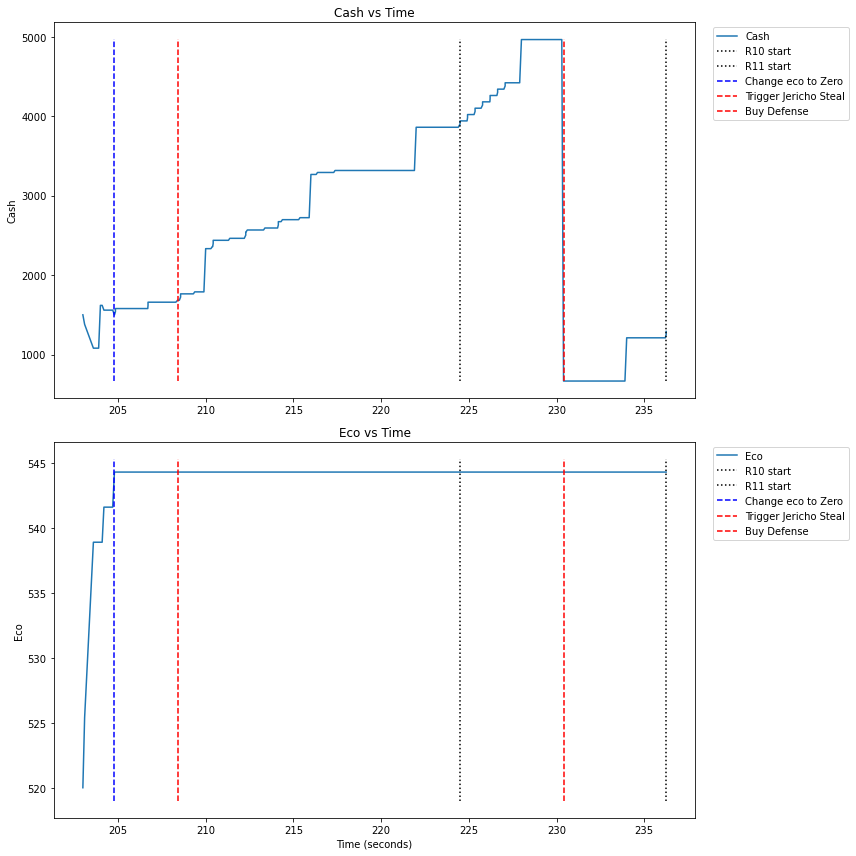

In [6]:
game_state = b2.GameState(initial_state_game)
game_state.fastForward(target_round = 11)
game_state.viewCashEcoHistory((12,12))
print("The current cash and eco are (%s,%s)"%(game_state.cash, game_state.eco))

## Optimization with the Bisection Method

A powerful use case for the simulator is to perform strategy *optimization*. In the above for example, we see that we afford the necromancer upgrade just fine. But what if our starting eco was lower. Could we still afford it okay? In general, what's the lowest eco amount we could have while still being able to afford necro at the right time? To answer this question, we perform optimization using the bisection method as follows:

In [7]:
def foo(starting_eco):
    buy_queue = [
        [b2.jerichoSteal(steal_amount = 25, min_buy_time = rounds.getTimeFromRound(9.25))],
        [b2.buyDefense(2800+1500, min_buy_time = rounds.getTimeFromRound(10.5))]
    ]

    eco_queue = [
        b2.ecoSend(rounds.getTimeFromRound(9) + 1.8, 'Zero', property = 'Normal', max_send_amount = None)
    ]

    initial_state_game = {
        'Cash': 1500,
        'Eco': starting_eco,
        'Eco Send': 'Spaced Zebras',
        'Rounds': rounds,
        'Game Round': 9,
        'Farms': farms,
        'Buy Queue': buy_queue,
        'Eco Queue': eco_queue
    }
    game_state = b2.GameState(initial_state_game)
    game_state.fastForward(target_round = 11)

    if len(game_state.buy_queue) == 0:
        return True
    else:
        return False

In [8]:
eco_bound_low = 250
eco_bound_high = 530
iterations = 25

for i in range(iterations):
    c = 0.5*(eco_bound_low + eco_bound_high)

    if foo(c) == True:
        eco_bound_high = c
    else:
        eco_bound_low = c

print("The minimum eco which lets us afford necro is %s"%('{0:.1f}'.format(0.5*(eco_bound_low + eco_bound_high))))

The minimum eco which lets us afford necro is 304.9


## Eco Numbers and the Early Game

When it comes to optimal eco'ing, it helps to know just how aggressively you can eco on R1 while still being able to purchase your hero and necessary defense before R2 starts. Using the eco simulator, we can test these values by utilizing the `max_send_amount` feature with the `b2.ecoSend()` function. This functionality forces the eco sim to switch to the next item in the eco queue (or the zero send if the queue is empty) after enough sets of the current send have been sent. Consider an example where we are playing tack wiz farm with jericho and need to purchase 120 tack and jericho on Round 1.

The current cash and eco are (4.400000000000091,279.4000000000001)


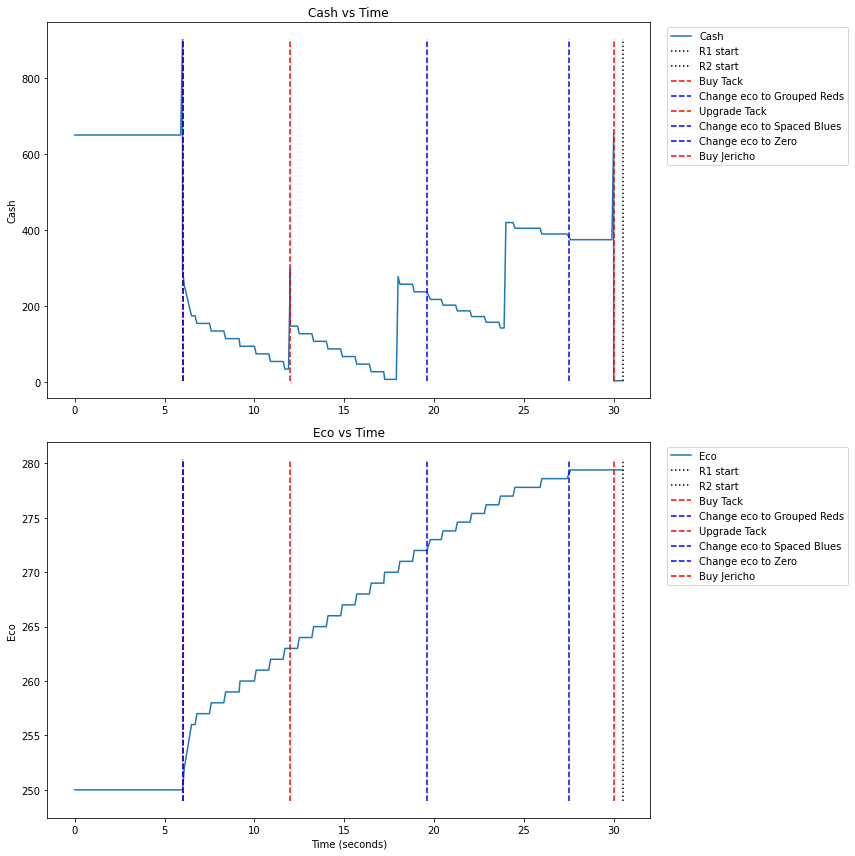

In [9]:
rounds = b2.Rounds(0.5)

buy_queue = [
    [b2.buyDefense(280 + 100 + 225, min_buy_time = rounds.getTimeFromRound(1), message = "Buy Tack")], #Buy 020 tack
    [b2.buyDefense(150, min_buy_time = rounds.getTimeFromRound(1) + 6, message = "Upgrade Tack")], #Upgrade to 120 tack
    [b2.buyDefense(650, min_buy_time = rounds.getTimeFromRound(1.5), message = "Buy Jericho")] #Buy Jericho
]

eco_queue = [
        b2.ecoSend(rounds.getTimeFromRound(1), 'Grouped Reds', max_send_amount = 23),
        b2.ecoSend(rounds.getTimeFromRound(2), 'Spaced Blues', max_send_amount = 8)
]

initial_state_game = {
    'Cash': 650,
    'Eco': 250,
    'Eco Send': 'Zero',
    'Rounds': rounds,
    'Game Round': 0,
    'Buy Queue': copy.deepcopy(buy_queue),
    'Eco Queue': copy.deepcopy(eco_queue)
}

game_state = b2.GameState(initial_state_game)
game_state.fastForward(target_round = 2)
game_state.viewCashEcoHistory((12,12))
print("The current cash and eco are (%s,%s)"%(game_state.cash, game_state.eco))
b2.writeLog(game_state.logs, filename = 'eco_numbers')

## Eco Numbers and the Late Game

We can also tell the simulator to abandon an eco send once we have acquired enough eco by using an argument called `max_eco_amount`. This is helpful for strategies which entail stopping eco once a certain amount of eco has been reached. The most useful application for this is in late-game optimization scenarios, where it is helpful to know just how much eco to acquire before stopping to afford essential defense.

Twitch streamer spoonoil is famous for his utilization of spac + alch in BAS (boat, alch, spac) to leverage large rushes while also effectively protecting against the counter rush. In the following example, we start from Round 24 in a quarter-stalled game with access to 4 favored trades and determine how much pink eco spoonoil should eco to before stopping to save up and buy essential defense. The essential purchases are given like so:

| Build Item | Time to Purchase |
|------------|------------------|
| 025 Spac | Round 27.9 |
| 502 Spac | Round 29.9 |

At this point in the tutorial documents, we have not given much detail about how boat farms work. For more details, we ask the player to view `actions.py`. Let's start by defining the *static* parts of our flowchart, or the things we *don't* need to optimize:

In [35]:
rounds = b2.Rounds(0.25)

buy_queue = [
    [b2.buyDefense(37150, message = "025 spac", min_buy_time = rounds.getTimeFromRound(27.9))],
    [b2.buyDefense(124650, message = "502 spac", min_buy_time = rounds.getTimeFromRound(29.9))]
]

boat_farms = {
    0: b2.initBoatFarm(purchase_time = rounds.getTimeFromRound(24), upgrade = 4),
    1: b2.initBoatFarm(purchase_time = rounds.getTimeFromRound(24), upgrade = 4),
    2: b2.initBoatFarm(purchase_time = rounds.getTimeFromRound(24), upgrade = 4),
    3: b2.initBoatFarm(purchase_time = rounds.getTimeFromRound(24), upgrade = 4),
}

eco_queue = [
    b2.ecoSend(rounds.getTimeFromRound(32), 'Zero') 
    #Because we are going to set a max_eco_amount on our grouped pinks,
    #we will stop eco'ing well before R32 likely.
]

Next, I'm going to define a function and put the parts of the flowchart I *do* need to optimize in there. In this case, the amount of eco we need to stop at is not clear. The function will, from a given indicated `stopping_eco`, return 'True' if we buy both our upgrades in the buy_queue on time and 'False' otherwise.

In [30]:
def foo(stopping_eco, rounds, eco_queue, buy_queue, boat_farms):

    initial_state_game = {
        'Cash': 0,
        'Eco': 3500,
        'Eco Send': 'Grouped Pinks',
        'Max Eco Amount': stopping_eco,
        'Rounds': rounds,
        'Game Round': 24,
        'Boat Farms': copy.deepcopy(boat_farms),
        'Buy Queue': copy.deepcopy(buy_queue),
        'Eco Queue': copy.deepcopy(eco_queue)
    }

    game_state = b2.GameState(initial_state_game)

    #First, check if we get permaspike on or before R28.
    #Next, check if we get spiked mines on or before R30
    game_state.fastForward(target_round = 28)
    if len(game_state.buy_queue) > 1:
        return False
    
    game_state.fastForward(target_round = 30)
    if len(game_state.buy_queue) > 0:
        return False
    else:
        return True

In [31]:
#Determine the *best* stopping time
stopping_eco_low = 3500
stopping_eco_high = 10000
iterations = 25

for i in range(iterations):
    c = 0.5*(stopping_eco_low + stopping_eco_high)

    if foo(c, rounds, eco_queue, buy_queue, boat_farms) == True:
        stopping_eco_low = c
    else:
        stopping_eco_high = c

max_stopping_eco = 0.5*(stopping_eco_low + stopping_eco_high)
print("The maximum stopping eco for the simulation is %s"%('{0:.1f}'.format(max_stopping_eco)))

The maximum stopping eco for the simulation is 6106.4


Finally, let's verify that what the simulator says actually holds true...

The current cash and eco are (25.99999999492138,6106.399999999718)


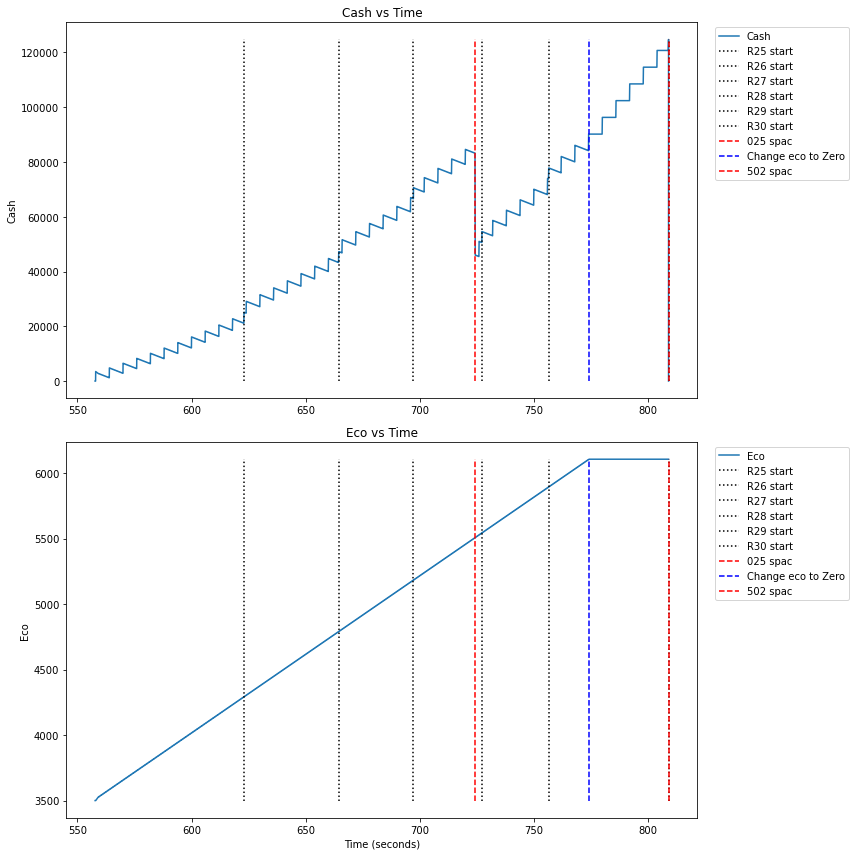

In [34]:
initial_state_game = {
        'Cash': 0,
        'Eco': 3500,
        'Eco Send': 'Grouped Pinks',
        'Max Eco Amount': max_stopping_eco - 1,
        'Rounds': rounds,
        'Game Round': 24,
        'Boat Farms': copy.deepcopy(boat_farms),
        'Buy Queue': copy.deepcopy(buy_queue),
        'Eco Queue': copy.deepcopy(eco_queue)
    }

game_state = b2.GameState(initial_state_game)
game_state.fastForward(target_round = 30)
game_state.viewCashEcoHistory((12,12))
print("The current cash and eco are (%s,%s)"%(game_state.cash, game_state.eco))
b2.writeLog(game_state.logs, filename = 'bas_lategame')

As a fair word of warning, while the simulator faitfully simulates all money-making mechanics of the game with virtually perfect accuracy, the challenge of bringing these optimizations into a real-game scenario comes from uncertainty surrounding actual round lengths. Nonetheless, the results from the sim can help improve game sense, and we see from the above that we can eco through the permaspike purchase and even well into R29 while still affording spiked mines in time for round 30.